# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: man

Last Name: pan

Student ID: 914656278

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [109]:
import sqlite3 as sql
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from mpl_toolkits.basemap import Basemap
import folium
import geopandas as gpd   
import sqlalchemy as sqla
import zipcode

In [110]:
db = sql.connect("D:\sf_data.sqlite")
pd.read_sql("SELECT * FROM sqlite_master", db)

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."


In [111]:
pm_1=pd.read_sql("select Applicant,count(distinct locationid) as number from mobile_food_permits,mobile_food_schedule where mobile_food_schedule.permit = mobile_food_permits.permit and mobile_food_permits.Status = 'APPROVED' group by Applicant", db)

In [112]:
pm_2=pm_1.sort_values(['number'], ascending=False)  
pm_2.index=range(0,len(pm_2['number']))
pm_2.head()

,Applicant,number
0,Park's Catering,23
1,D & T Catering,17
2,F & C Catering,13
3,Munch A Bunch,10
4,Eva's Catering,8


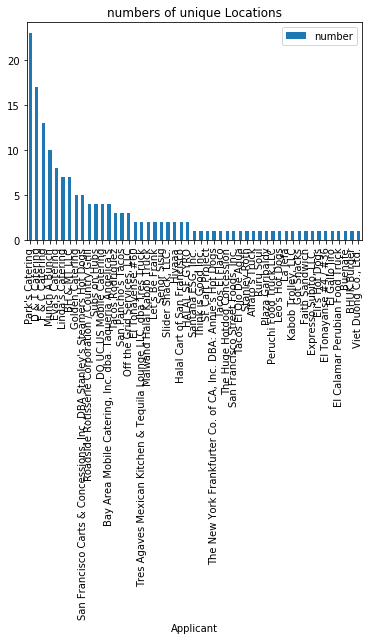

In [113]:
pm_2.plot(x = 'Applicant', kind = 'bar', title = 'numbers of unique Locations')
plt.show()

By connecting mobile_food_permits and mobile_food_schedule with the common column permit, I can calculate the number of locations for each permit, Applicant. Then I sort the location numbers from high to low.

we can see that mobile food vendor "Park's Catering" sells at the most locations: 23. And locations number of "D&T Catering" and "F&C Catering" are also larger, which are 17 and 13.

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

## Which parts of the city are the most and least expensive?

In [114]:
zillow = pd.read_sql('select * from zillow', db)
zillow.head()

,RegionName,Date,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
0,94109,2010-11-01 00:00:00,3.156,675.1913,19.14,6.0771
1,94110,2010-11-01 00:00:00,2.566,599.6785,18.10,5.4490
2,94122,2010-11-01 00:00:00,2.168,495.4432,17.99,2.4198
3,94080,2010-11-01 00:00:00,1.666,369.5538,18.31,3.8757
4,94112,2010-11-01 00:00:00,2.322,422.4538,14.44,3.1288


In [115]:
zillow_1 = zillow[np.isfinite(zillow['MedianSoldPricePerSqft_AllHomes'])]
zillow_1.index=range(0,len(zillow_1['MedianSoldPricePerSqft_AllHomes']))
zillow_1.head()

,RegionName,Date,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
0,94109,2010-11-01 00:00:00,3.156,675.1913,19.14,6.0771
1,94110,2010-11-01 00:00:00,2.566,599.6785,18.10,5.4490
2,94122,2010-11-01 00:00:00,2.168,495.4432,17.99,2.4198
3,94080,2010-11-01 00:00:00,1.666,369.5538,18.31,3.8757
4,94112,2010-11-01 00:00:00,2.322,422.4538,14.44,3.1288


In [116]:
sql_query_1 = """
select RegionName, MedianSoldPricePerSqft_AllHomes
from zillow
order by "MedianSoldPricePerSqft_AllHomes" desc
"""
zillow_2 = pd.read_sql(sql_query_1, db)
zillow_2.head()

,RegionName,MedianSoldPricePerSqft_AllHomes
0,94104,1336.128581
1,94123,1286.297641
2,94123,1276.685200
3,94105,1276.585300
4,94105,1270.436000


In [117]:
list=[]
most_exp = zillow_1.loc[zillow_1['MedianSoldPricePerSqft_AllHomes'].idxmax()]
least_exp = zillow_1.loc[zillow_1['MedianSoldPricePerSqft_AllHomes'].idxmin()]
most_zip = most_exp['RegionName']
least_zip = least_exp['RegionName']
list.append(most_exp)
list.append(least_exp)
list

[RegionName                                       94104
 Date                               2007-10-01 00:00:00
 ZriPerSqft_AllHomes                                NaN
 MedianSoldPricePerSqft_AllHomes                1336.13
 PriceToRentRatio_AllHomes                          NaN
 Turnover_AllHomes                               22.973
 Name: 3682, dtype: object,
 RegionName                                       94124
 Date                               1996-10-01 00:00:00
 ZriPerSqft_AllHomes                                NaN
 MedianSoldPricePerSqft_AllHomes                103.938
 PriceToRentRatio_AllHomes                          NaN
 Turnover_AllHomes                                  NaN
 Name: 1166, dtype: object]

In [118]:
most_loc = [zipcode.isequal('94104').lat,zipcode.isequal('94104').lon]
least_loc = [zipcode.isequal('94124').lat,zipcode.isequal('94124').lon]

In [119]:
most_loc

[37.79, -122.4]

In [120]:
least_loc

[37.73, -122.38]

In [121]:
map_1 = folium.Map(location= (37.76, -122.45), zoom_start= 13)
map_1

In [122]:
folium.Marker(least_loc, popup='Least Expensive Parts').add_to(map_1)
folium.CircleMarker(most_loc, popup='Most Expensive Parts',radius=500,color='#3186cc',fill_color='#3186cc').add_to(map_1)
map_1

According to the question of Which parts of the city are the most and least expensive, I use table "zillow". Based on the “Median Sold Price PerSqft AllHomes” , I select the most and least expensive RegionName. By using regionname, I use the pyzipcode package to get the longitude and latitude of that location. Then, I install folium package. By folium package, I get the map of SF, I also can add the most and the least expensive locations to the map. I choose to use differet ways to marker the two places, I use the simplest way to locate the least expensive place, and use the circle style marker to marker the most expensive part. From the final map, we can see the most expensive parts are located around the Montgomery Street and the Pine Street. And the least expensive parts are located on the Bayview Street, which can be detected from map clearly.

## Which parts of the city are the most dangerous (and at what times)?

In [123]:
crime = pd.read_sql('select * from crime', db)
crime.head()

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469


In [124]:
sql_query_1 = """
select count(distinct IncidntNum) number_of_crime, PdDistrict, DayOfWeek
from crime
group by PdDistrict, DayOfWeek
order by "number_of_crime" desc
"""
crime_time_place = pd.read_sql(sql_query_1, db)
crime_time_place.head()

,number_of_crime,PdDistrict,DayOfWeek
0,24869,SOUTHERN,Friday
1,23963,SOUTHERN,Saturday
2,22209,SOUTHERN,Wednesday
3,22003,SOUTHERN,Thursday
4,20946,SOUTHERN,Tuesday


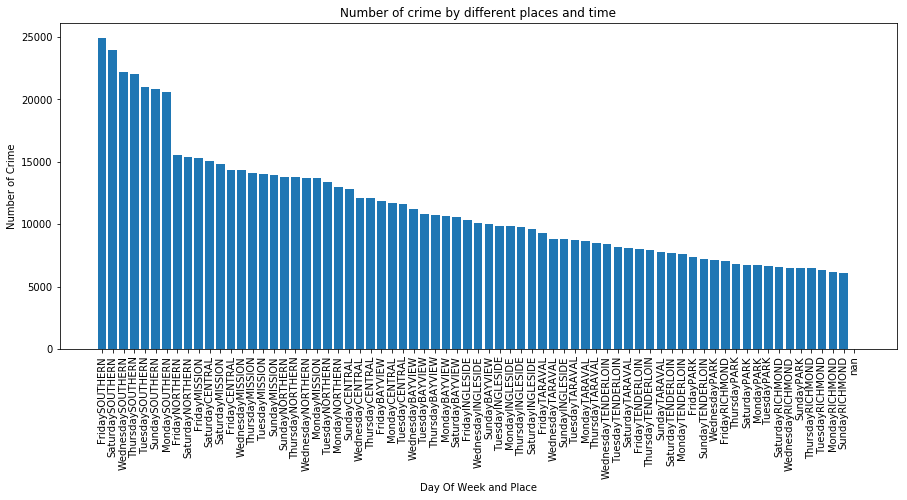

In [125]:
x = range(len(crime_time_place))
plt.figure(figsize=(15, 6))
labels = crime_time_place['DayOfWeek'] + crime_time_place['PdDistrict']
plt.xticks(x, labels, rotation = 'vertical')
plt.bar(x, crime_time_place['number_of_crime'])
plt.xlabel('Day Of Week and Place')
plt.ylabel('Number of Crime')
plt.title('Number of crime by different places and time')
plt.show()

In [126]:
sql_query_2 = """
select count(distinct IncidntNum) number_of_crime, DayOfWeek
from crime
group by DayOfWeek
order by "number_of_crime" desc
"""
crime_time = pd.read_sql(sql_query_2, db)
crime_time.head()

,number_of_crime,DayOfWeek
0,123861,Friday
1,118402,Saturday
2,114583,Wednesday
3,112178,Thursday
4,110484,Tuesday


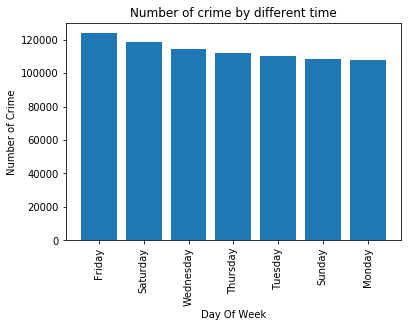

In [127]:
x = range(len(crime_time))
labels = crime_time_place['DayOfWeek'] 
plt.xticks(x, labels, rotation = 'vertical')
plt.bar(x, crime_time['number_of_crime'])
plt.xlabel('Day Of Week')
plt.ylabel('Number of Crime')
plt.title('Number of crime by different time')
plt.show()

In [128]:
sql_query_3 = """
select count(distinct IncidntNum) number_of_crime, PdDistrict
from crime
group by DayOfWeek
order by "number_of_crime" desc
"""
crime_place = pd.read_sql(sql_query_3, db)
crime_place.head()

,number_of_crime,PdDistrict
0,123861,INGLESIDE
1,118402,TARAVAL
2,114583,CENTRAL
3,112178,RICHMOND
4,110484,SOUTHERN


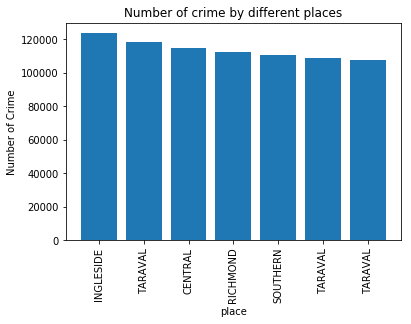

In [129]:
x = range(len(crime_place))
labels = crime_place['PdDistrict']
plt.xticks(x, labels, rotation = 'vertical')
plt.bar(x, crime_place['number_of_crime'])
plt.xlabel('place')
plt.ylabel('Number of Crime')
plt.title('Number of crime by different places')
plt.show()

According to the question of the time and the place are the most dangerous , I use table "crime" and select incident number, day of week and district to deal with that question. Firstly, I count the number of distinct incident numbers by district and day of week, I also play the bar plot for crime number with time and place, and I find that the most dangerous time and part of the city is Friday in Southern district, the number of crime incidents is 24869. Then, I count the incident number by day of week, the bar plot tells me that the most dangerous time is Friday, the number of incidents is 123861. Lastly, I count the incident number by place, the bar plot tells me that the most dangerous place is ingleside, the number of incidents is 123861. So, we can conclude that people will be much easierly in a crime incident in Friday, in Southern district of San Francisco. So, it will be better for people not come to those places at those time.

## Are noise complaints and mobile food vendors related?

In [130]:
noise = pd.read_sql('select * from noise', db)
noise.head()

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon
0,5130305,other_excessive_noise,Not associated with a specific address,None,2015-09-25 00:29:33,NaN,NaN
1,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475
2,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365
3,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943
4,5930704,other_excessive_noise,"1360 43RD AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 13:58:43,37.761385,-122.502232


In [131]:
sql_query_3_1 ="""select "Lat" as lat,"Lon" as lon from noise where lat != '' and lon != '' """
noise_location = pd.read_sql_query(sql_query_3_1,db)
noise_location.head()

,lat,lon
0,37.769148,-122.424475
1,37.762047,-122.508365
2,37.787983,-122.414943
3,37.761385,-122.502232
4,37.742435,-122.420087


In [132]:
sql_query_3_2 = """
select distinct Latitude as lat, Longitude as lon
from mobile_food_locations l
inner join mobile_food_schedule s on s.locationid = l.locationid
inner join mobile_food_permits p on p.permit = s.permit
where Status = 'APPROVED' and Longitude < 0
"""
mobile_vendor_location = pd.read_sql_query(sql_query_3_2, db)
mobile_vendor_location.head()

,lat,lon
0,37.753109,-122.388170
1,37.754252,-122.389381
2,37.769829,-122.400101
3,37.780561,-122.392849
4,37.774871,-122.398532


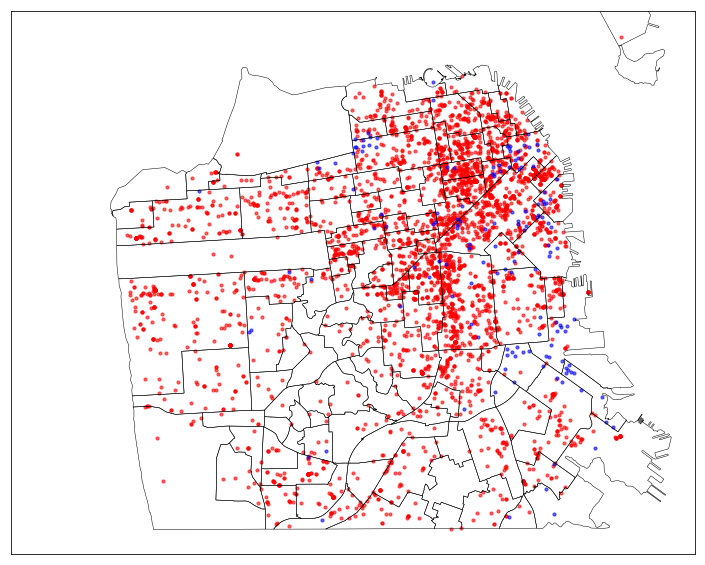

In [133]:
fig, ax1 = plt.subplots(figsize=(15, 10))
cmap = Basemap(llcrnrlat=37.7026, urcrnrlat=37.8236, llcrnrlon=-122.5430, urcrnrlon=-122.3503,
               resolution='i',projection='merc')
cmap.readshapefile("D:\SF Find Neighborhoods\geo_export_eaf4471e-0815-4302-b254-5bdec24e463d", 'comarques')
x1,y1 = cmap(np.array(noise_location.lon),np.array(noise_location.lat))
x2,y2 = cmap(np.array(mobile_vendor_location.lon),np.array(mobile_vendor_location.lat))
cmap.scatter(x1,y1,s=10,c='r',marker="o",alpha=0.6)
cmap.scatter(x2,y2,s=10,c='b',marker="o",alpha=0.6)

As for the question of Are noise complaints and mobile food vendors related, I separetely get the locations of noise and the locations of the mobile vendor. Then I want to prensent them in the same map, which will be markered by different color. So that I can detect the relation between noise complaints and mobile food vendors clearly. From the map, we know the blue are the mobile vendors, and the red are noise complaints.we see that the majority of mobile vendors are located at the east, which are 
nearby the downtown. But noise complaints are scattered completely. For example, although there are so many noise in the 5th street, there are no food trucks because trucks maybe influnce the traffic. Also, maybe the place have so many stores which will produce huge noise, people can go to stores to have the lunch rather than food trucks. So that we cannot find clearly relationship between noise complaints and mobile food vendors.

## What are the best times and places to find food trucks?

In [134]:
query_4 = """
select "Address" as address,"DayOfWeek" as day, "EndHour" as end_time, "StartHour" as start_time, count(*) as count from mobile_food_schedule 
join mobile_food_locations on mobile_food_schedule.locationid = mobile_food_locations.locationid 
join mobile_food_permits on mobile_food_schedule.permit = mobile_food_permits.permit 
where "FacilityType" == 'Truck'
group by Address, day
order by count desc
"""
truck = pd.read_sql(query_4, db)
truck.head()

,address,day,end_time,start_time,count
0,400 HOWARD ST,Th,14,11,8
1,400 HOWARD ST,Tu,14,11,8
2,Assessors Block /Lot,Mo,11,10,8
3,400 HOWARD ST,Fr,17,16,7
4,400 HOWARD ST,Mo,17,16,7


As for the question of What are the best times and places to find food trucks, I use three tabels: mobile_food_locations, mobile_food_schedule and mobile_food_permits. I select four items: address, day ,end_time and start_time to compare. If the facility type is truck and the locationis is the same in the three tables, I count the number from mobile_food_schedule. Then I sort the numbers from high to low.
I find that the best place is at 400 Howard ST, the best time are Th and Tu at noon. We can see that 400 Howard ST is the best place to sell food at the lunch time and the dinner time. I also find that location is the downtown, so many of people will be here, and they have to eat food at noon and night. Because of the heavy traffic at downtown and busy working, people will be more likely to get food at food trucks, which are much more convinent and quickly. The same thing as shopping people.

## where are most of schools located? What is the distribution of public and private school? 

public_schools = pd.read_sql("SELECT Name, GradeRange, Category, Entity, Lat, Lon \
                           FROM schools \
                           WHERE GradeRange = '9-12' AND (Entity = 'Community College District' OR Entity = 'SFUSD')"
                           , db)
public_schools.head()

In [135]:
private_schools = pd.read_sql("SELECT Name, GradeRange, Category, Entity, Lat, Lon \
                              FROM schools \
                              WHERE Entity = 'Private'"
                              , db)
private_schools.head()

,Name,GradeRange,Category,Entity,Lat,Lon
0,Adda Clevenger School,K-8,Independent / Private,Private,37.753738,-122.424461
1,Alt School - Alamo Square,K-5,Independent / Private,Private,37.774788,-122.430206
2,Alt School - Dogpatch 1,TK-2,Independent / Private,Private,37.761177,-122.388130
3,Alt School - Dogpatch 2,TK-2,Independent / Private,Private,37.760662,-122.387962
4,Alt School - Fort Mason,K-8,Independent / Private,Private,37.804562,-122.433907


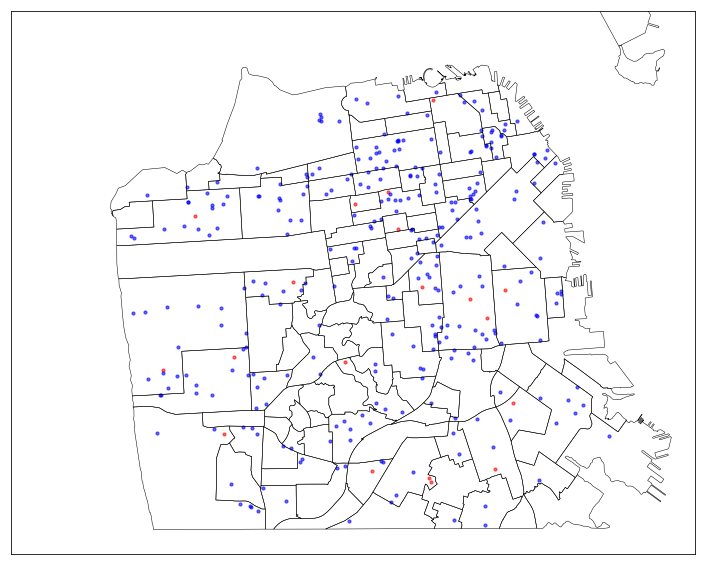

In [136]:
fig, ax1 = plt.subplots(figsize=(15, 10))
pm_map = Basemap(llcrnrlat=37.7026, urcrnrlat=37.8236, llcrnrlon=-122.5430, urcrnrlon=-122.3503,
               resolution='i',projection='merc')
pm_map.readshapefile("D:\SF Find Neighborhoods\geo_export_eaf4471e-0815-4302-b254-5bdec24e463d", 'comarques')
x3,y3 = pm_map(np.array(public_schools.Lon),np.array(public_schools.Lat))
x4,y4 = pm_map(np.array(private_schools.Lon),np.array(private_schools.Lat))
cmap.scatter(x3,y3,s=10,c='r',marker="o",alpha=0.6)
cmap.scatter(x4,y4,s=10,c='b',marker="o",alpha=0.6)

As for the question of where are most of schools located, we have to see the two kinds of points together, we can find that schools are scattered evenly for most schools. But the north has a little more schools than the south. And also there are many schools centralized in the upper and right of the map. Also, there is no schools in the most southeast and most southwest of the map.
As for the question of the distribution of public and private school, I choose red markers to represent public schools and select blue remarkers to represent private schools. I can find that the number of private schools are much larger than the number of the public schools. Both of them are scattered evenly. 
We all know schools are most located the places where have more people, so we can conclude that the population are larger in the north, compared to the south. So the traffic and the life also will be more convenient in the north.